In [11]:
from fractions import Fraction
from typing import Iterable, Tuple

from mingus.extra import lilypond
from mingus.midi.midi_file_out import write_Composition

from evolution import HarmonyGene, genetic_algorithm, TournamentSelection, EarlyStopping
from mingus_utils import create_composition, test_melody, test_chords, create_melody
from utils import note_match_fitness, note_mismatch_penalty, chord_progression_fitness

from IPython.display import Image, Audio

In [12]:
def fitness(gene: HarmonyGene, melody: Iterable[Tuple[Tuple[str, Fraction]]], key: str) -> float:
    melody_notes = set(note[0] for bar in melody for note in bar)

    fitness = 0
    for chord, bar in zip(gene, melody):
        bar_notes = set(note[0] for note in bar)
        fitness += note_match_fitness(chord, bar_notes)
        fitness -= 0.7 * note_mismatch_penalty(chord, bar_notes)
        fitness -= 0.3 * note_mismatch_penalty(chord, melody_notes)

    fitness += chord_progression_fitness(gene.gene, key)

    return fitness

In [13]:
# only diatonic chords
alphabet = ["F", "Gm", "Am", "Bb", "C", "Dm", "Edim"]
key = "F"
n_population = len(test_melody)

print("Alphabet", alphabet)
initial_pop = HarmonyGene.initialize_population(n_population * 10, n_population, alphabet)
generated_chords, score = genetic_algorithm(
    lambda x: fitness(x, test_melody, key),
    initial_pop,
    TournamentSelection(5),
    p_crossover=0.8,
    p_mutation=0.3,
    epochs=500,
    callbacks=[EarlyStopping(30)]
)
print("Best score:", score)
print("Generated chords", generated_chords)

gen_comp = create_composition(test_melody, generated_chords)
write_Composition("generated.midi", gen_comp)
write_Composition("correct.midi", create_composition(test_melody, test_chords))

Alphabet ['F', 'Gm', 'Am', 'Bb', 'C', 'Dm', 'Edim']
Best score: 1.0833333333333335
Generated chords HarmonyGene(['C', 'F', 'C', 'C', 'F'])


True

# Sample output visualised

### Initial melody

{ { \time 1/4 c''8. c''16 } { \time 3/4 d''4 c''4 f''4 } { e''2 c''8. c''16 } { d''4 c''4 g''4 } { \time 1/2 f''2 } }
Executing: lilypond -fpng -o "melody" "melody.ly"


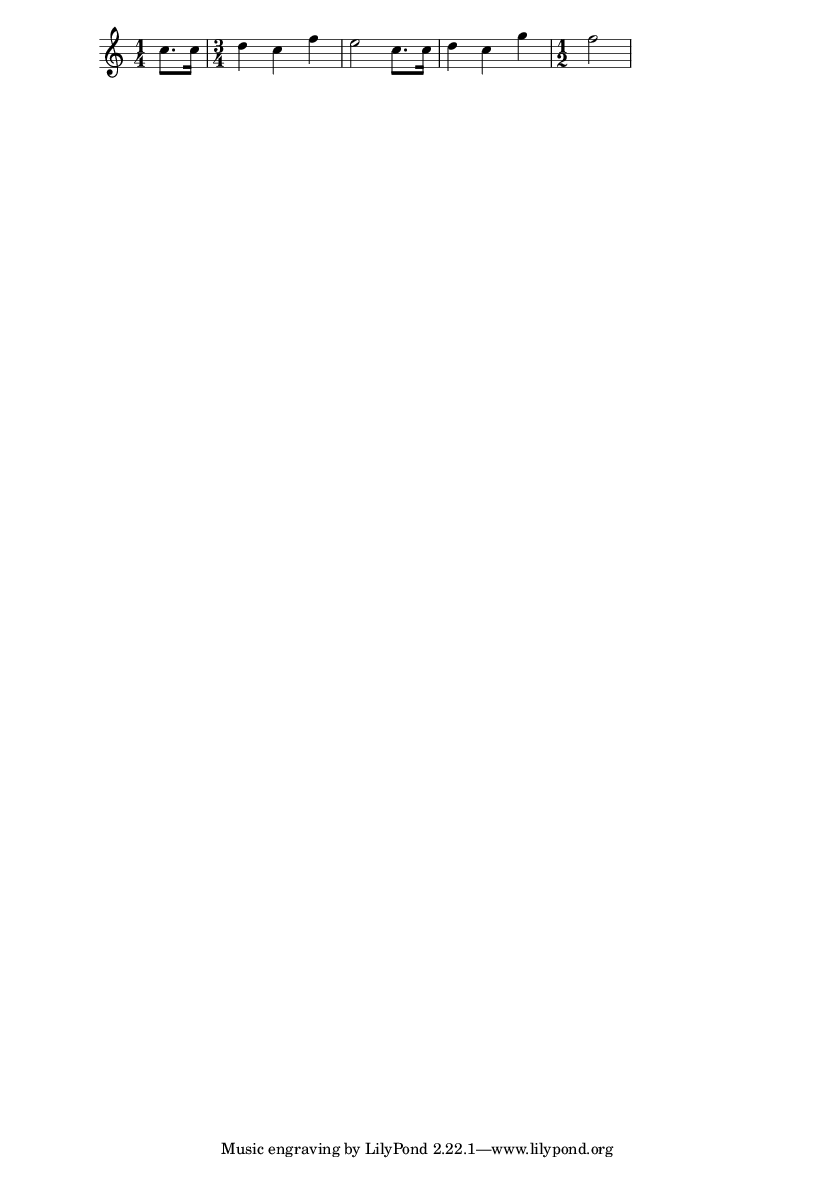

In [14]:
melody = lilypond.from_Track(create_melody(test_melody))
print(melody)
lilypond.to_png(melody, "melody.png")
Image(filename='melody.png')

### Generated chords

\header { title = "Untitled" composer = "" opus = "" } { { \time 1/4 c''8. c''16 } { \time 3/4 d''4 c''4 f''4 } { e''2 c''8. c''16 } { d''4 c''4 g''4 } { \time 1/2 f''2 } } { { \time 1/4 <c' e' g'>4 } { \time 3/4 <f' a' c''>2. } { <c' e' g'>2. } { <c' e' g'>2. } { \time 1/2 <f' a' c''>2 } }
Executing: lilypond -fpng -o "gen_comp" "gen_comp.ly"


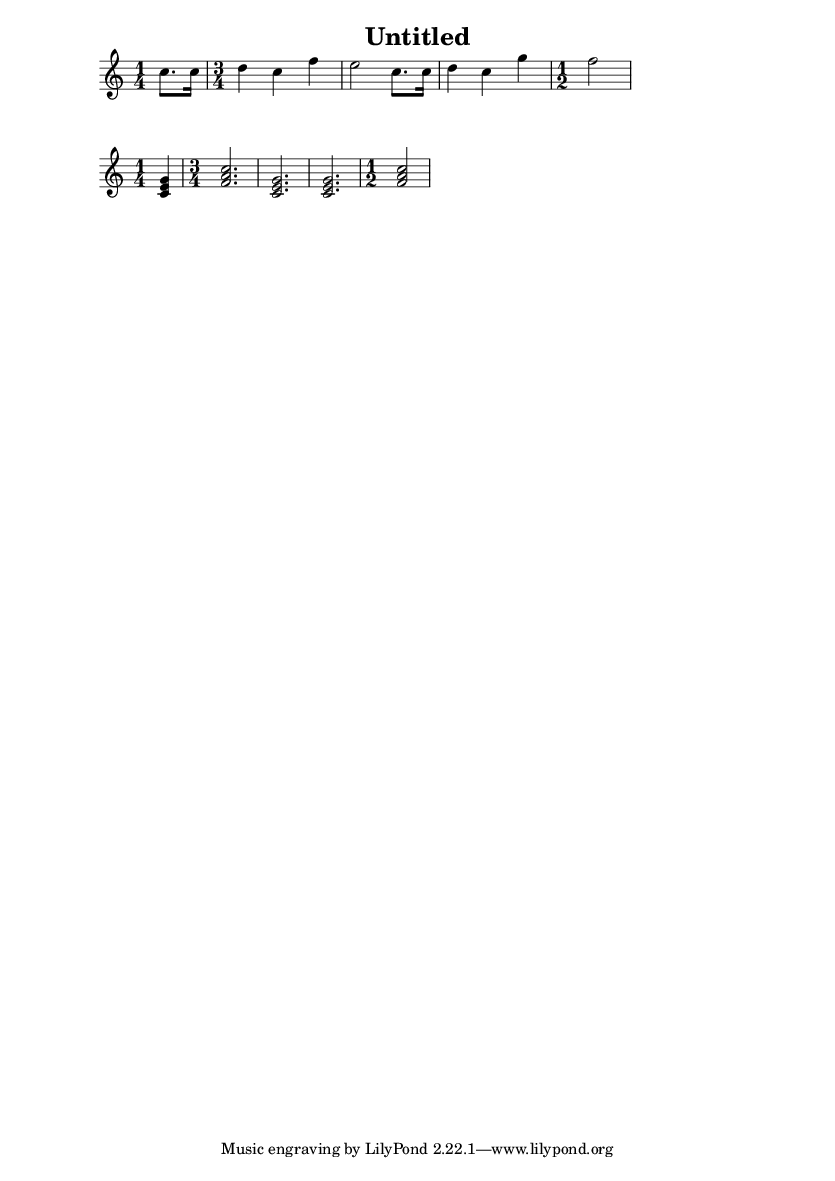

In [15]:
comp = lilypond.from_Composition(gen_comp)
print(comp)
lilypond.to_png(comp, "gen_comp.png")
Image(filename='gen_comp.png')